## Emotion Detection in text

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
import re, string, unicodedata
from string import punctuation

Getting the data out of the CSV file

In [2]:
df = pd.read_csv("tweet_emotions.csv")


Seeing the first 5 rows of the dataset to get a simple understanding of what it contains

In [3]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


The shape shows how many columns and how many rows the dataset contains.

In [4]:
df.shape

(40000, 3)

Checking if there are any empty rows in the dataset

In [5]:
df.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

We drop the tweet id columns since it does not give any valuable information

In [6]:
df.drop(columns= "tweet_id",inplace = True)

We check how many of each emotion is in our dataset

In [7]:
df["sentiment"].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

To get more of an overview, we make a barplot to visualize

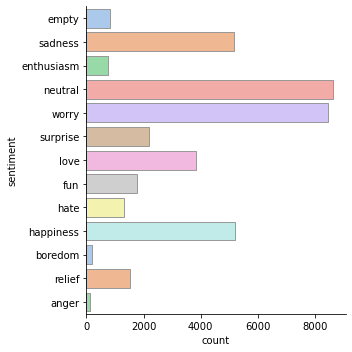

In [8]:
sns.catplot(y="sentiment", kind="count",
            palette="pastel", edgecolor=".6",
            data=df)

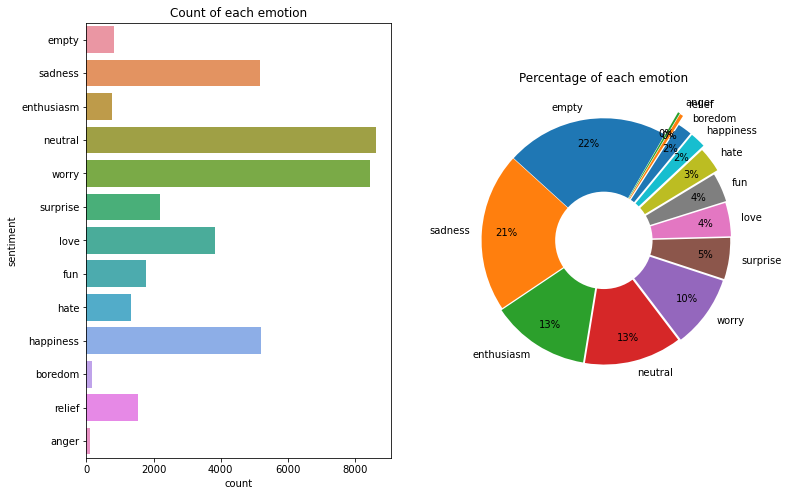

In [47]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df["sentiment"].dropna().value_counts()))/sum(list(df["sentiment"].dropna().value_counts())))[::-1])[:]
labels = list(df["sentiment"].dropna().unique())[:]
sizes = df["sentiment"].value_counts()[:]

ax2.pie(sizes,  explode=explode, startangle=60, labels=labels, autopct='%1.0f%%', pctdistance=0.8)
ax2.add_artist(plt.Circle((0,0),0.4,fc='white'))
sns.countplot(y="sentiment", data=df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

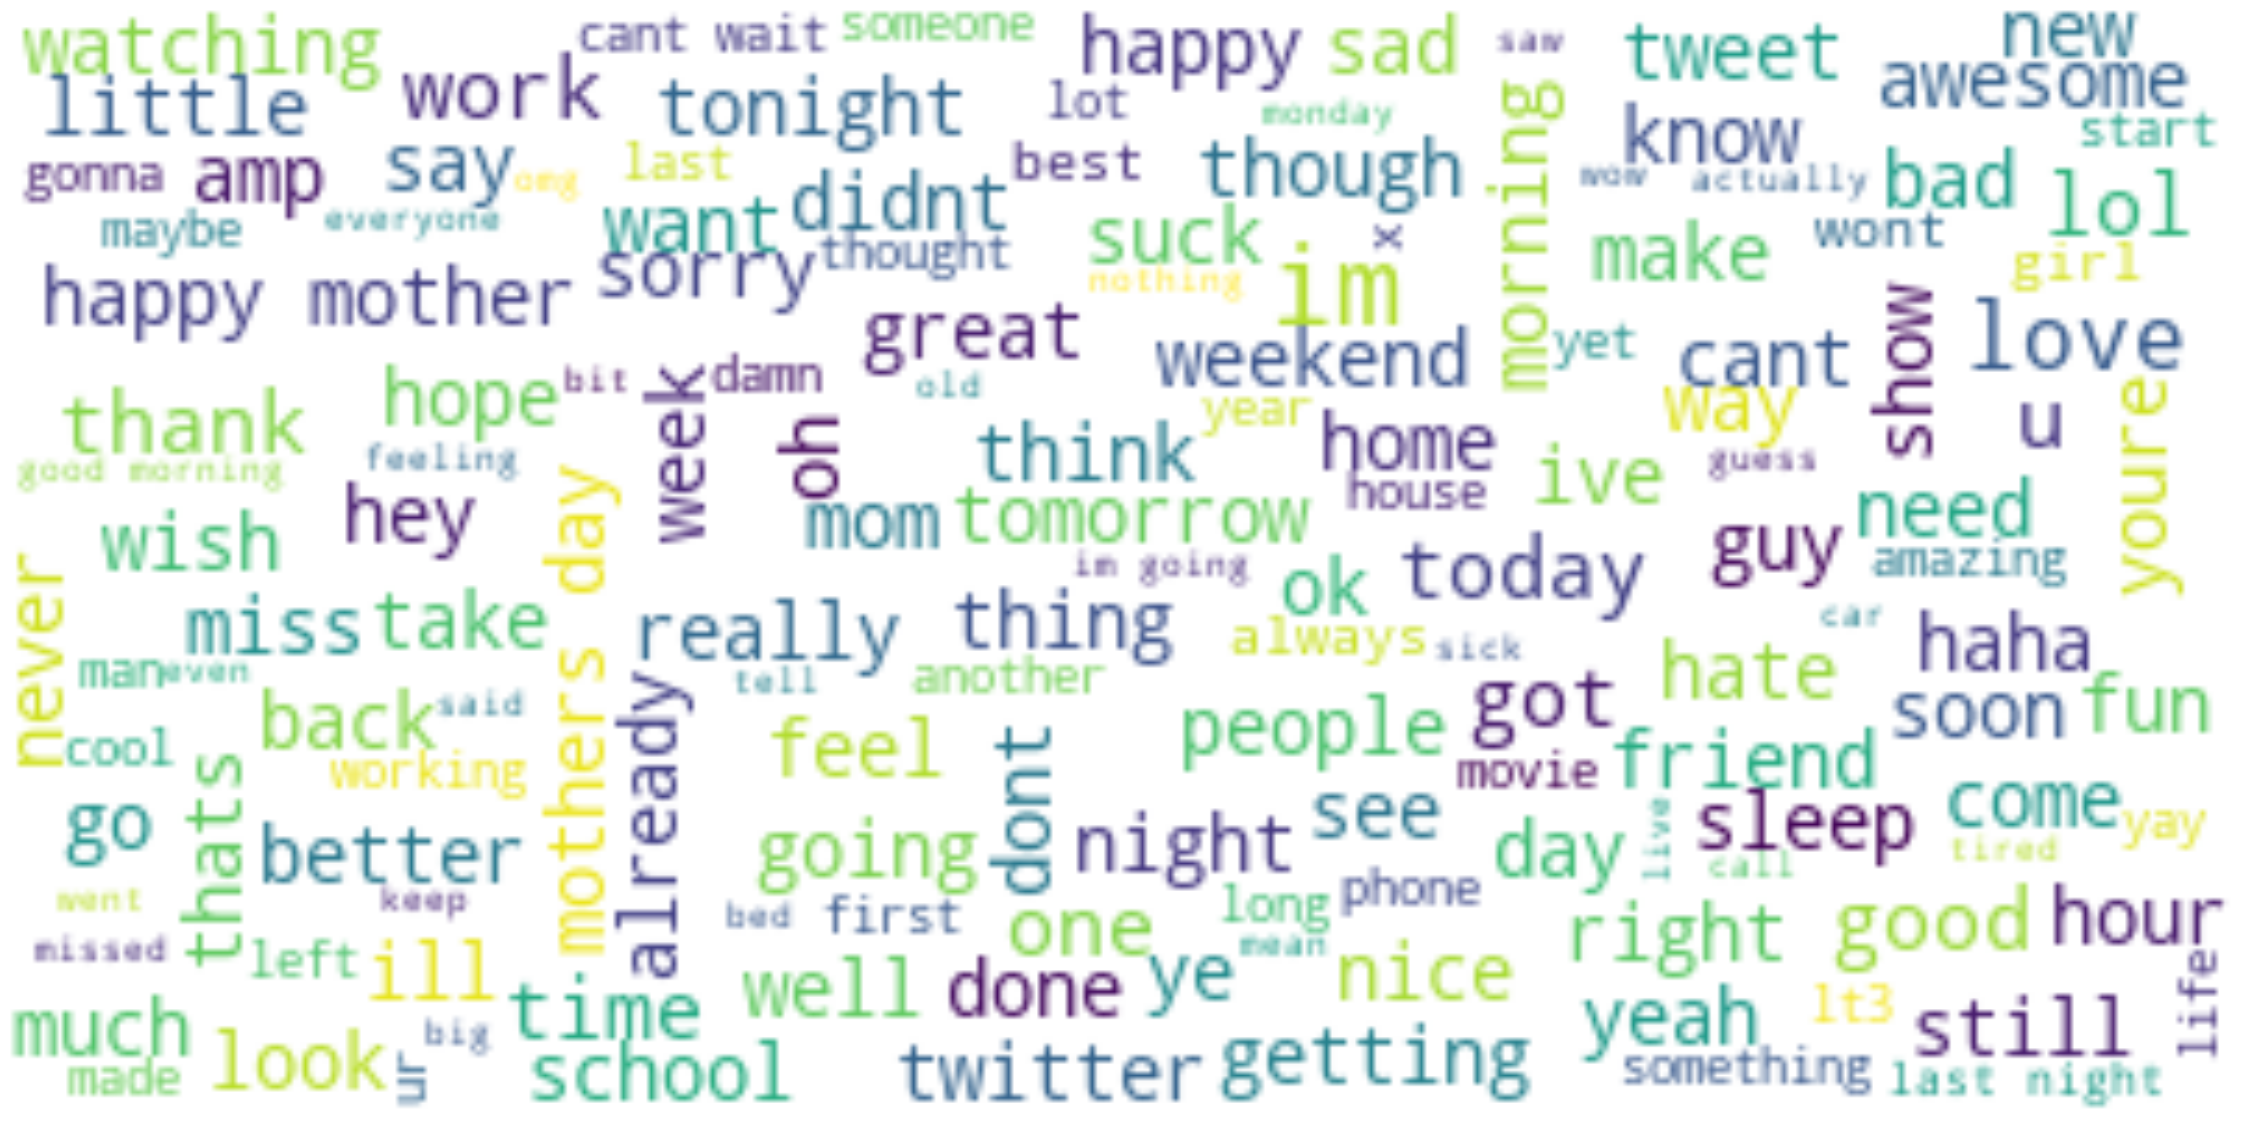

In [52]:
from wordcloud import WordCloud

text = " ".join(cat for cat in df["content"])

wordcloud = WordCloud(max_font_size=20, max_words=150, background_color="white").generate(text)
plt.figure(figsize=(40,40))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Preprocessing

The text contains allot of symbols that will not be compatible with machine learning, I write a function to remove these sumbols:

In [84]:
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def remove_emoji(text):
    regex_pattern = re.compile("["                               
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U0001F1E6-\U0001F1FF"  # flags                              
                               "]+", flags=re.UNICODE)

    return regex_pattern.sub(r'', text)


def remove_email(text):
    return re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', '', text)


def remove_repeated_char(text):
    return re.sub(r'(.)\1\1{1,}', r'\1\1', text)


def remove_account_tag(text):
    return re.sub(r'@[\w]+', '', text)


def remove_hashtag(text):
    return re.sub(r'#[\w]+', '', text)


def remove_links(text):
    return re.sub(r'http[^\s]+', '', text)


def remove_spaces(text):
    text = re.sub(r"\d+", ' ', text)
    text = re.sub(r"\n+", ' ', text)
    text = re.sub(r"\t+", ' ', text)
    text = re.sub(r"\r+", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    return text


def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    return " ".join([w for w in word_tokens if not w in stop_words])


def remove_less_2_characters(text):
    return re.sub(r"\W*\b\w{1,2}\b", '', text)


def lemmatize(text):
    new_text = []
    tokenization = nltk.word_tokenize(text)
    for w in tokenization:
        tmp_w = wordnet_lemmatizer.lemmatize(w)
        if tmp_w is None:
            new_text.append(w)
        else:
            new_text.append(tmp_w)
    return " ".join(new_text)


def preprocess_text_sample(text):
    text = remove_emoji(text)
    text = remove_email(text)
    text = remove_repeated_char(text)
    text = remove_account_tag(text)
    text = remove_hashtag(text)
    text = remove_links(text)
    text = remove_stop_words(text)
    text = remove_spaces(text)
    text = remove_less_2_characters(text)
    text = text.strip()
    text = text.lower()
    #text = spelling_fix(text)
    text = lemmatize(text)
    return text


def preprocess_text_cols(df, col):
    df[col] = df[col].apply(lambda x: preprocess_text_sample(x))
    return df


def preprocess_df(df, col="content"):
    df = preprocess_text_cols(df, col)
    df.dropna(inplace=True)
    return df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\megin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\megin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\megin\AppData\Roaming\nltk_data...


We "apply" the fucntion to the column with the text "content"

In [85]:
df = preprocess_df(df, "content")
df = df[df["content"] != ""]
df

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,layin bed headache ughhwaitin call
2,sadness,funeral ceremonygloomy friday
3,enthusiasm,want hang friend soon
4,neutral,dannycastillo want trade someone houston ticke...
...,...,...
39995,neutral,johnlloydtaylor
39996,love,happy mother day love
39997,love,happy mother day mommy woman man long youre mo...
39998,happiness,niariley wassup beautiful follow peep new hit ...


our machine learning model will take the words most seen with each emotion and predict text emotion based on that, most of these tweets are normally formed sentences. This means that most of the rows contain stop words, such as; since, and, so. These words are not specifically connected to an emotion and can be removed. 

In [87]:
import nltk
nltk.download('stopwords')

sw_list = stopwords.words("english")

df['content'] = df['content'].apply(lambda x: [item for item in x.split() if item not in sw_list]).apply(lambda x:" ".join(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\megin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\megin\AppData\Local\Temp\ipykernel_4312\2347127175.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].apply(lambda x: [item for item in x.split() if item not in sw_list]).apply(lambda x:" ".join(x))


In [88]:
df

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,layin bed headache ughhwaitin call
2,sadness,funeral ceremonygloomy friday
3,enthusiasm,want hang friend soon
4,neutral,dannycastillo want trade someone houston ticke...
...,...,...
39995,neutral,johnlloydtaylor
39996,love,happy mother day love
39997,love,happy mother day mommy woman man long youre mo...
39998,happiness,niariley wassup beautiful follow peep new hit ...


We split the emotion and the text into 2 different vairbales

In [89]:
X = df.iloc[:,1:2]
y = df["sentiment"]

In [90]:
y.head()

0         empty
1       sadness
2       sadness
3    enthusiasm
4       neutral
Name: sentiment, dtype: object

Since machine learning works best with numbers, we convert all the emotions into numbers using the library labelencoder

In [91]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(y)

In [92]:
y

array([ 2, 10, 10, ...,  7,  5,  7])

In [93]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [94]:
X_train.shape

(31977, 1)

In [95]:
y_test.shape

(7995,)

## Text

In [96]:
#Applying bag of words
from sklearn.feature_extraction.text import CountVectorizer

In [97]:
cv = CountVectorizer()

In [98]:
X_train_bow = cv.fit_transform(X_train['content']).toarray()
X_test_bow = cv.transform(X_test['content']).toarray()

In [99]:
X_train_bow.shape

(31977, 39227)

## Modeling

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).

In [100]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb.fit(X_train_bow,y_train)

MultinomialNB()

In [101]:
y_pred = mnb.predict(X_test_bow)

from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(y_test,y_pred)

0.3028142589118199

In [102]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial')

lr.fit(X_train_bow,y_train)

C:\Users\megin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [103]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00       161
           3       0.00      0.00      0.00       153
           4       0.00      0.00      0.00       344
           5       0.33      0.31      0.32      1043
           6       1.00      0.01      0.02       286
           7       0.51      0.29      0.37       769
           8       0.33      0.35      0.34      1790
           9       0.00      0.00      0.00       311
          10       0.28      0.11      0.16      1012
          11       0.20      0.00      0.00       438
          12       0.27      0.70      0.39      1634

    accuracy                           0.30      7995
   macro avg       0.22      0.14      0.12      7995
weighted avg       0.30      0.30      0.25      7995



In [104]:
def predict(model,text):
    text=pd.Series(text)
    pred=model.predict(text)
    print(enc.classes_[pred][0])
    ## inference


In [106]:
 nltk.download('maxent_ne_chunker')
 nltk.download('words')
 nltk.download('punkt')
 nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\megin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping chunkers\maxent_ne_chunker.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\megin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\megin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\megin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [107]:
sentence = "We saw the yellow dog"
tokens = nltk.word_tokenize(sentence)
print(tokens)

tagged = nltk.pos_tag(tokens)

entities = nltk.chunk.ne_chunk(tagged)
print(entities)

['We', 'saw', 'the', 'yellow', 'dog']
(S We/PRP saw/VBD the/DT yellow/JJ dog/NN)


In [111]:
from nltk.corpus import wordnet as wn
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def get_sentiment(word,tag):
    """ returns list of pos neg and objective score. But returns empty list if not present in senti wordnet. """

    wn_tag = penn_to_wn(tag)
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

def get_sentiment_binary(word,tag):
    print(f"get_sentiment(x,y): {get_sentiment(X,y)}")
    aux = get_sentiment(X,y)
   
    if not aux:
        return 0
   
    return aux[0]-aux[1]

def check_sentence(sentence):
    result = 0
    tokens = nltk.word_tokenize(sentence)
    print(f"tokens: {tokens}")
    pos_val = nltk.pos_tag(tokens)
    print(f"pos_val: {pos_val}")    
    for (x,y) in pos_val:
        print(f"{X} => {y}")
        print(f"get_sentiment_binary(x,y): {get_sentiment_binary(X,y)}")
        result = result +get_sentiment_binary(X,y)
    return result

In [113]:
predict(mnb,"i'm very happy to see you" )

ValueError: could not convert string to float: "i'm very happy to see you"